Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [8]:
passengers_count = df['Passengers'].to_numpy(dtype='float32')
passengers_count

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.], dtype=float32)

Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [79]:
timeseries = df.sort_index(inplace=False, ascending=True)
last_train_index = int(len(timeseries) * 0.67)
train, test = timeseries[0:last_train_index], timeseries[last_train_index:len(timeseries)]

In [80]:
train.shape, test.shape

((96, 1), (48, 1))

**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [81]:
import torch

def create_dataset(dataset, lookback=1):
    X, Y = [], []
    for i in range(len(dataset) - lookback):
        seq = dataset.iloc[i:i+lookback].values
        target = dataset.iloc[i + lookback]
        X.append(seq)
        Y.append(target)
    X, Y = np.array(X), np.array(Y)
    X, Y = X.reshape(X.shape[0], -1), Y.reshape(Y.shape[0], -1)
    X_tensor, Y_tensor = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)
    return X_tensor, Y_tensor

In [150]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [151]:
from torch import nn

class AirModel(nn.Module):
    def __init__(self, input_size=1, hidden_size= 50, num_layers=1, batch_first=True):
        super(AirModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=batch_first)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [152]:
input_tensor = X_train.reshape(X_train.shape[0], lookback, 1)
model = AirModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100

def train_model(input_tensor, y_train, model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        outputs = model(input_tensor)
        optimizer.zero_grad()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        model.eval()


In [153]:
train_model(input_tensor, y_train, model, criterion, optimizer, num_epochs)

Epoch [10/100], Loss: 50352.2109
Epoch [20/100], Loss: 49117.2617
Epoch [30/100], Loss: 47685.7070
Epoch [40/100], Loss: 46487.8086
Epoch [50/100], Loss: 45306.8203
Epoch [60/100], Loss: 44166.5781
Epoch [70/100], Loss: 43067.7383
Epoch [80/100], Loss: 42006.3359
Epoch [90/100], Loss: 40978.3281
Epoch [100/100], Loss: 39980.3984


**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [155]:
from torch.utils.data import TensorDataset, DataLoader

# 1. Створюємо датасет із X_train та y_train
train_dataset = TensorDataset(X_train, y_train)

# 2. Створюємо DataLoader з batch_size=8
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

train_loader

**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [87]:
def train_model_with_dataloader_and_validation(model, train_loader, criterion, optimizer, num_epochs, X_test, y_test, print_every=100, lookback=1):
  '''
  Trains the given model using the provided DataLoader, criterion, and optimizer for a specified number of epochs.
  Args:
      model (nn.Module): The neural network model to be trained.
      train_loader (DataLoader): DataLoader providing the training data in batches.
      criterion (nn.Module): Loss function to be used for training.
      optimizer (torch.optim.Optimizer): Optimizer to update the model parameters.
      num_epochs (int): Number of epochs to train the model.
      X_test (torch.Tensor): Test input data for validation.
      y_test (torch.Tensor): Test target data for validation.
      print_every (int): Frequency of printing training progress.
      lookback (int): Number of time steps to look back for each input sequence.
  Returns:
        list: A list containing the training loss for each epoch.
  '''
  losses = []
  X_test_seq = X_test.reshape(X_test.shape[0], lookback, 1)
  for epoch in range(num_epochs):
      model.train()
      epoch_loss = 0.0
      for xb, yb in train_loader:
          xb_seq = xb.reshape(xb.shape[0], lookback, 1)
          optimizer.zero_grad()
          outputs = model(xb_seq)
          loss = criterion(outputs, yb)
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item() * xb.size(0)
      train_rmse = (epoch_loss / len(train_loader.dataset)) ** 0.5
      losses.append(train_rmse)
      with torch.no_grad():
          model.eval()
          val_output = model(X_test_seq)
          val_rmse = (criterion(val_output, y_test).item()) ** 0.5

      if (epoch+1) % print_every == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], train RMSE: {train_rmse:.4f}, val RMSE: {val_rmse:.4f}')

  return losses

In [156]:
model = AirModel()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 2000

losses = train_model_with_dataloader_and_validation(model, train_loader, criterion, optimizer, num_epochs=num_epochs, X_test=X_test, y_test=y_test)

Epoch [100/2000], train RMSE: 190.1999, val RMSE: 384.8062
Epoch [200/2000], train RMSE: 160.4638, val RMSE: 352.9869
Epoch [300/2000], train RMSE: 132.9122, val RMSE: 322.2548
Epoch [400/2000], train RMSE: 109.6270, val RMSE: 294.3372
Epoch [500/2000], train RMSE: 91.1056, val RMSE: 269.0726
Epoch [600/2000], train RMSE: 74.4864, val RMSE: 245.0023
Epoch [700/2000], train RMSE: 61.0001, val RMSE: 222.4264
Epoch [800/2000], train RMSE: 50.0870, val RMSE: 201.7200
Epoch [900/2000], train RMSE: 42.2584, val RMSE: 183.0835
Epoch [1000/2000], train RMSE: 35.9028, val RMSE: 166.6140
Epoch [1100/2000], train RMSE: 32.3917, val RMSE: 152.6136
Epoch [1200/2000], train RMSE: 29.3039, val RMSE: 140.9357
Epoch [1300/2000], train RMSE: 27.8076, val RMSE: 131.1159
Epoch [1400/2000], train RMSE: 26.3198, val RMSE: 123.9619
Epoch [1500/2000], train RMSE: 26.8717, val RMSE: 118.0208
Epoch [1600/2000], train RMSE: 25.0332, val RMSE: 113.1167
Epoch [1700/2000], train RMSE: 24.5730, val RMSE: 109.6998
Ep

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

In [157]:
def loss_plot(losses):
    plt.figure(figsize=(10,5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()

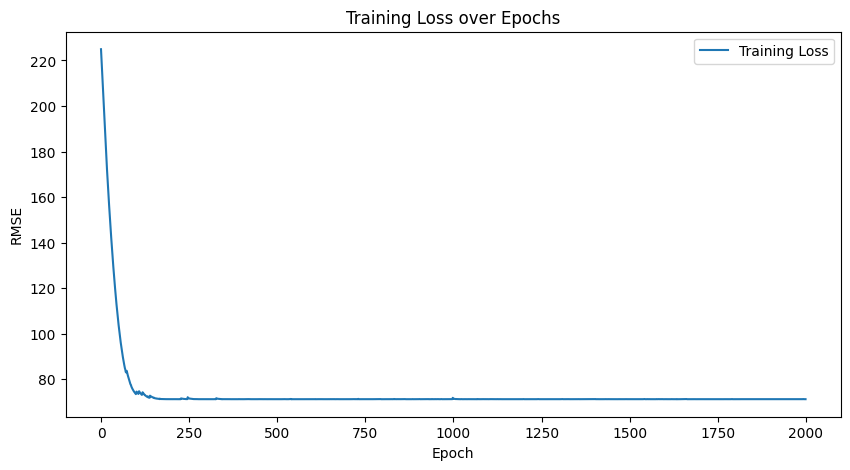

In [77]:
loss_plot(losses)

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

47


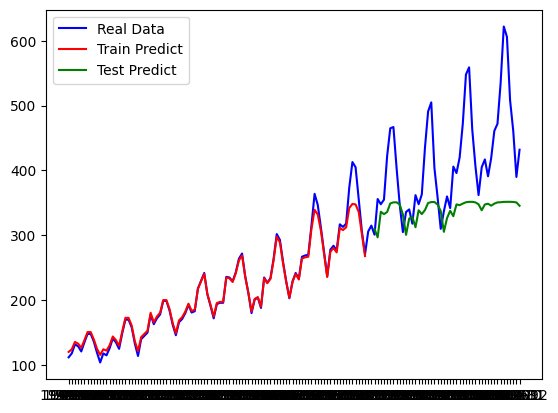

In [158]:
def plot_predicts(model=model, lookback=lookback):
  with torch.no_grad():
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(timeseries) * np.nan
      train = X_train.reshape(X_train.shape[0], lookback, 1)
      y_pred = model(train)
      train_size = len(train)
      train_plot[:train_size] = model(train)
      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(timeseries) * np.nan
      test = X_test.reshape(X_test.shape[0], lookback, -1)
      print(X_test.shape[0])
      test_plot[train_size+2:len(timeseries)] = model(test)

  # Візуалізація результатів
  plt.plot(timeseries, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  legend = ['Real Data', 'Train Predict', 'Test Predict']
  plt.legend(legend)
  plt.show()

plot_predicts(model=model, lookback=lookback)

Модель навчилась на попередніх періодах проте не завершила навчання на останніх періодах тому варто збільшити період навчання щоб передбачення були більш точними

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [159]:
hidden_size = 100
model_2 = AirModel(hidden_size=hidden_size)
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 2000

train_model_with_dataloader_and_validation(model_2, train_loader, criterion, optimizer, num_epochs=num_epochs, X_test=X_test, y_test=y_test)

Epoch [100/2000], train RMSE: 146.9484, val RMSE: 337.8968
Epoch [200/2000], train RMSE: 97.5012, val RMSE: 278.1351
Epoch [300/2000], train RMSE: 68.3158, val RMSE: 233.8705
Epoch [400/2000], train RMSE: 48.4696, val RMSE: 197.0428
Epoch [500/2000], train RMSE: 36.9247, val RMSE: 168.0127
Epoch [600/2000], train RMSE: 30.7637, val RMSE: 145.7694
Epoch [700/2000], train RMSE: 27.0663, val RMSE: 128.2223
Epoch [800/2000], train RMSE: 26.6910, val RMSE: 116.1012
Epoch [900/2000], train RMSE: 24.8628, val RMSE: 107.8209
Epoch [1000/2000], train RMSE: 23.8242, val RMSE: 102.2317
Epoch [1100/2000], train RMSE: 26.5697, val RMSE: 100.4631
Epoch [1200/2000], train RMSE: 25.6131, val RMSE: 95.1507
Epoch [1300/2000], train RMSE: 24.3128, val RMSE: 96.3859
Epoch [1400/2000], train RMSE: 24.1979, val RMSE: 91.6914
Epoch [1500/2000], train RMSE: 23.8908, val RMSE: 92.5116
Epoch [1600/2000], train RMSE: 26.4007, val RMSE: 87.7969
Epoch [1700/2000], train RMSE: 24.1199, val RMSE: 86.2020
Epoch [1800

[225.93553103895647,
 225.44372602042773,
 224.88563257461968,
 224.10767180276372,
 223.18516502337954,
 222.0574376894944,
 220.486255110005,
 219.18942912197156,
 218.2872588697481,
 217.26552602597152,
 216.30244914604862,
 215.2997680713543,
 214.28401974580618,
 213.20786222943883,
 212.2032670872435,
 211.31409374934097,
 210.4297197184596,
 209.41537837277653,
 208.25720887724896,
 206.88975748365297,
 205.80570277426204,
 204.79712667959262,
 203.81265494111187,
 202.84126742292074,
 201.8434205176131,
 200.91125739251018,
 200.00752925794674,
 199.12819482148137,
 198.23230605234087,
 197.37753140980266,
 196.51727002419702,
 195.67808584828808,
 194.82264771453035,
 194.01292845130192,
 193.17616614831954,
 192.3373254784519,
 191.4499398848375,
 190.61476320658542,
 189.7903762690356,
 188.98434035785456,
 188.15588780789273,
 187.3615799370649,
 186.56773487321885,
 185.77632454959888,
 184.98380324502313,
 184.21067532301305,
 183.4262432661968,
 182.6586430834635,
 181.8

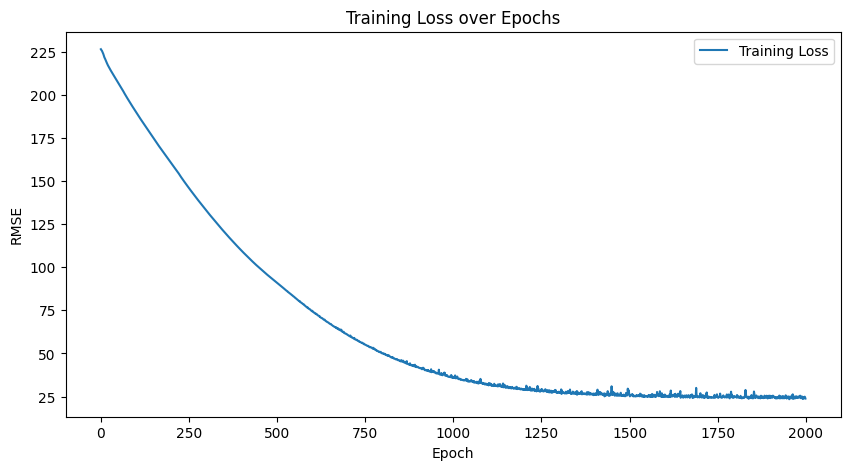

In [160]:
loss_plot(losses)

47


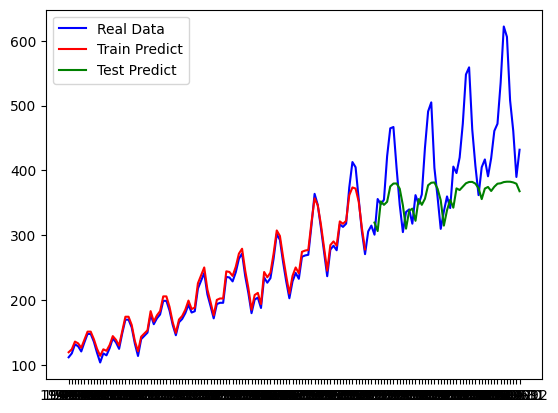

In [161]:
plot_predicts(model=model_2)

Після збільшення hidden_size з 50 до 100 та зменшення швидкості навчання до lr=0.001 якість моделі суттєво покращилась:

- тренувальний RMSE зменшився з ≈71 до ≈24;

- валідаційний RMSE зменшився з ≈215 до ≈84.

На графіку видно, що модель дуже добре відтворює історичні (train) дані, а на тестовому відрізку вже краще захоплює сезонність і загальний рівень ряду, ніж попередня модель.
Водночас модель усе ще недооцінює зростання пасажиропотоку в останні періоди: з кожним кроком уперед прогноз дещо “відстає” від реальних значень. Це означає, що модель добре вчиться на історичних даних, але її здатність до довгострокового прогнозування обмежена (ймовірно, через малий lookback та відсутність нормалізації/додаткових ознак).

Зі збільшенням hidden_size підвищується моделююча здатність (capacity),але й збільшує ризик overfitting.

Етапи покращення:

- збільшити значення lookback до 12 місяців

- нармалізувати дані з MinMaxScaler

- використовувати ранню зупинку по RMSE